# NON-LINEAR SVM 
A Non-Linear Support Vector Machine (SVM) is a machine learning algorithm used to classify data that cannot be separated by a straight line or hyperplane. It overcomes this limitation by using kernel functions to transform the data into a higher-dimensional space, where it can become linearly separable and thus easier to classify with a hyperplane.
Non-Linear SVM extends SVM to handle complex, non-linearly separable data using kernels. For example, one group of points might surround another group in a circle. A simple SVM won't work well here because it only draws straight lines.

Inshort,non-linear SVM can classify the data points which are non-linearly separable more "efficiently than linear SVM" by using "kernels".

# REFERENCES
Understanding the kernel trick (by Jason Brownlee)
https://machinelearningmastery.com/kernel-methods-for-machine-learning-with-python/

Kernels in SVM – Towards Data Science
https://towardsdatascience.com/support-vector-machines-svms-a-complete-guide-1c3b9dd45cb3

In [1]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


# let's first understand the mathematical concepts and formula that will be used to implement non linear SVM from scratch

## 📌 Non-Linear SVM – Mathematical Formulation

---

### **1. Primal Optimization Problem**

#$$\min_{w,b,\xi} \; \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i$$

#Subject to:

#$$y_i \big( w^T \phi(x_i) + b \big) \ge 1 - \xi_i, \;\; \xi_i \ge 0$$

#*Here, \( \phi(x) \) is the feature mapping to a higher-dimensional space, \( \xi_i \) are slack variables, and \( C \) is the regularization parameter.*

#**Explanation:**  
#- \( \phi(x) \) maps input to high-dimensional space  
#- \( C \) controls margin vs error trade-off  
#- \( \xi_i \) allows misclassification

#---

### **2. Dual Problem**

#$$\max_{\alpha} \; \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(x_i, x_j)$$

#Subject to:

#$$0 \le \alpha_i \le C, \quad \sum_{i=1}^n \alpha_i y_i = 0$$

#*Here, \( \alpha_i \) are Lagrange multipliers and \( K(x_i, x_j) \) is the kernel function.*

#---

### **3. Decision Function**

#$$f(x) = \sum_{i=1}^n \alpha_i y_i K(x_i, x) + b$$

#$$\hat{y} = \text{sign}(f(x))$$

#*Only support vectors contribute to the decision boundary. The kernel trick avoids explicit mapping.*

#Explanation:

#Uses only support vectors for prediction

#Kernel trick avoids explicit feature mapping
#---

### **4. Common Kernel Functions**

#**Linear Kernel:**

#$$K(x_i, x_j) = x_i^T x_j$$

#**Polynomial Kernel:**

#$$K(x_i, x_j) = (\gamma x_i^T x_j + r)^d$$

#**RBF (Gaussian) Kernel:**

#$$K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$$

#*RBF kernel captures non-linear relationships. \( \gamma \) controls the width of the Gaussian.*


#Explanation:

#RBF kernel handles non-linear decision boundaries

#controls the width of the Gaussian function
#---

### **5. Functional Margin**

#$$\gamma_i = y_i (w^T x_i + b)$$

#*A positive margin means correct classification, and a larger margin indicates better separation.*


#Explanation:

#Positive margin → correct classification

#Larger margin → better separation
#---

### **6. Bias Term Calculation**

#$$b = y_i - \sum_{j=1}^n \alpha_j y_j K(x_j, x_i)$$

#*Computed using any support vector where \( 0 < \alpha_i < C \).*

#---

### **7. KKT Conditions**

#$$\alpha_i \big( y_i f(x_i) - 1 + \xi_i \big) = 0$$

#*KKT conditions ensure optimality. Only support vectors influence the margin.*

#Explanation:

#Only support vectors influence the margin
#---

# now let's implement the SVM by keeping the above concepts in mind

In [2]:
# 2. Kernel SVM Class
class KernelSVM:
    def __init__(self, C=1.0, kernel='rbf', degree=3, gamma=0.5, max_iter=100):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.max_iter = max_iter

    def _kernel_function(self, X1, X2):
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'poly':
            return (1 + np.dot(X1, X2.T)) ** self.degree
        elif self.kernel == 'rbf':
            sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
            return np.exp(-self.gamma * sq_dists)
        else:
            raise ValueError("Unknown kernel")

    def fit(self, X, y):
        self.X = X
        self.y = y
        n_samples = X.shape[0]
        self.alphas = np.zeros(n_samples)
        self.b = 0
        self.accuracy_history = []

        # Compute kernel matrix
        K = self._kernel_function(X, X)

        for it in range(self.max_iter):
            for i in range(n_samples):
                # Compute decision function
                condition = y[i] * (np.sum(self.alphas * y * K[:, i]) + self.b)
                if condition < 1:
                    self.alphas[i] += self.C
                else:
                    self.alphas[i] -= self.C

            # Track accuracy on training set after each iteration
            y_pred = np.sign(self.project(X))
            acc = np.mean(y_pred == y)
            self.accuracy_history.append(acc)

        # Compute support vectors
        self.support_indices_ = np.where(self.alphas > 1e-5)[0]
        self.support_vectors_ = X[self.support_indices_]

    def project(self, X):
        K = self._kernel_function(X, self.X)
        return np.dot(K, self.alphas * self.y) + self.b

    def predict(self, X):
        return np.sign(self.project(X))



In [3]:
# 3. Load dataset
X, y = make_moons(n_samples=300, noise=0.1, random_state=42)
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# 4. Train SVM
svm = KernelSVM(C=0.01, kernel='rbf', gamma=1, max_iter=50)
svm.fit(X_train, y_train)

In [5]:
# 5. Predictions and Accuracy
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Number of support vectors: {len(svm.support_vectors_)}")
print("First 10 predictions:", y_pred[:10])
print("First 10 actual:", y_test[:10])


Accuracy: 100.00%
Number of support vectors: 145
First 10 predictions: [ 1.  1.  1.  1.  1. -1.  1. -1.  1.  1.]
First 10 actual: [ 1  1  1  1  1 -1  1 -1  1  1]


# Let's understand the same thing by visualizations

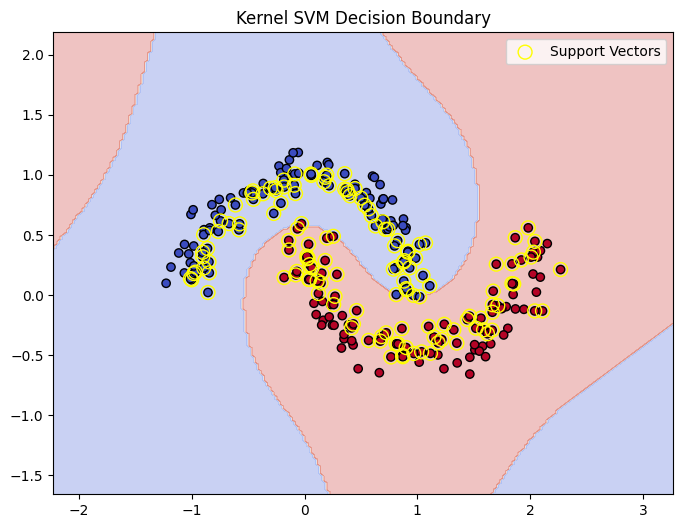

In [6]:
# 6. Decision Boundary Visualization
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='yellow', label='Support Vectors')
    plt.legend()
    plt.title("Kernel SVM Decision Boundary")
    plt.show()

plot_decision_boundary(svm, X_train, y_train)


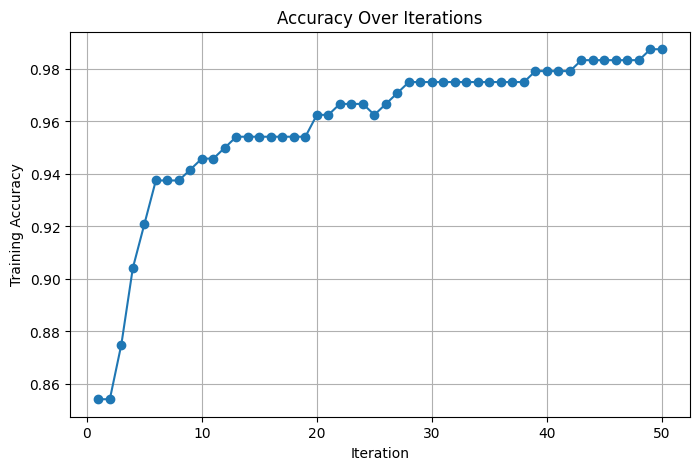

In [7]:
# 7. Accuracy over Iterations
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(svm.accuracy_history)+1), svm.accuracy_history, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.title("Accuracy Over Iterations")
plt.grid(True)
plt.show()

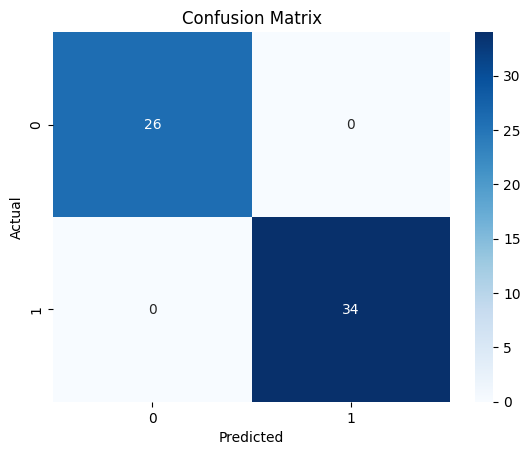

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [9]:
def plot_decision_boundary(svm, X, y):
    plt.figure(figsize=(8, 6))
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    # Compute decision function values
    Z = np.array([svm.project(np.array([p])) for p in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    
    # Plot contour
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50),
                 cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot original data
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, s=100, edgecolors='k')
    
    # Plot support vectors
    if hasattr(svm, 'support_vectors'):
        plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
                    s=200, facecolors='none', edgecolors='k')
    
    plt.title("Decision Boundary with Support Vectors")
    plt.show()

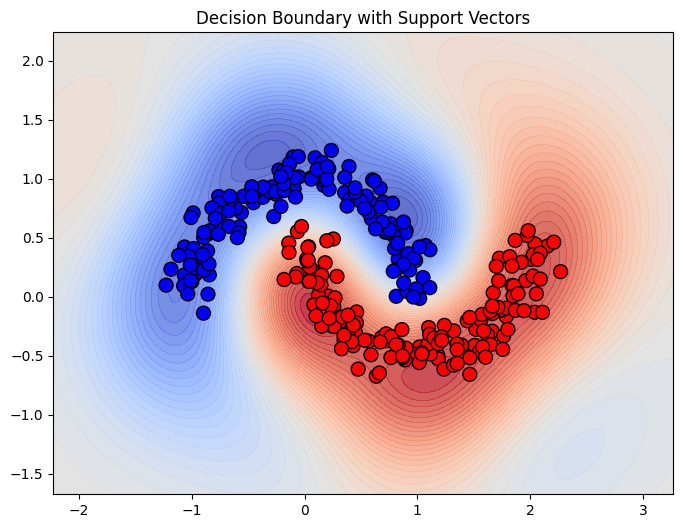

In [10]:
plot_decision_boundary(svm,X,y)

# CONCLUSION:-
#Finally,we succesfuly classified the non-linearly separable data-points using the concepts of non-linear SVM and their kernel-tricks.
#We use this to overcome the limitations of linear SVM which fails in the case of data points which are non-linearly separable.
#It uses kernels which reduces the data points in high dimensional space,where non-linearly separable data-points starts to look like lineary separable and then it does classifications.